# DS: start from here if generating plots, I think?

In [ ]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive, files
import pandas as pd
import pickle
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import numpy as np
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from peft import PeftModel
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from itertools import combinations
import umap

In [ ]:
drive.mount('/content/drive')
%cd /content/drive/MyDrive/6.8611 final project/

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/10KmyK1yEw0WioL8iUTO0ZpM7KwE7Ofnx/6.8611 final project


In [ ]:
# load data
songs_df = pd.read_csv('./year_limited_songs.csv')

In [ ]:
# load label encoder, get number of classes
with open('./distilbert_models/label_encoder.pkl', 'rb') as f:
  label_encoder = pickle.load(f)

num_labels = len(label_encoder.classes_)

# load base model, adapter
base_model = AutoModelForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=num_labels
)
model = PeftModel.from_pretrained(base_model, './distilbert_models/dbert_run_25')

# load tokenizer
tokenizer = AutoTokenizer.from_pretrained('./distilbert_models/')

# move model to GPU, set to eval mode for inference
model = model.to('cuda')
model.eval()

batch_size = 64
all_lyrics = list(songs_df['lyrics'])
cls_embeddings = []

# process lyrics in batches
for i in range(0, len(all_lyrics), batch_size):
  batch_lyrics = all_lyrics[i:i + batch_size]
  tokenized_batch = tokenizer(batch_lyrics, padding=True, truncation=True, return_tensors="pt").to('cuda')

  with torch.no_grad():
    outputs = model(**tokenized_batch, output_hidden_states=True)
    embeddings_before_softmax = outputs.hidden_states[-2][:, 0, :]

    cls_embeddings.append(embeddings_before_softmax.cpu().numpy())

  # free GPU memory for batch
  del tokenized_batch, outputs, embeddings_before_softmax
  torch.cuda.empty_cache()

# concatenate embeddings
cls_embeddings = np.concatenate(cls_embeddings, axis=0)
print(f"CLS embeddings shape: {cls_embeddings.shape}")

# normalize embeddings, reduce dims w PCA
normalized_embeddings = StandardScaler().fit_transform(cls_embeddings)
reduced = PCA(n_components=50).fit_transform(normalized_embeddings)

# further reduce dims w TSNE
graphable = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=15).fit_transform(reduced)

print(f"Graphable shape: {graphable.shape}")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.5.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CLS embeddings shape: (34400, 768)
Graphable shape: (34400, 2)


In [ ]:
# only run if you need to save
np.save('./cls_embeddings.npy', cls_embeddings)
np.save('./reduced.npy', reduced)
np.save('./graphable.npy', graphable)

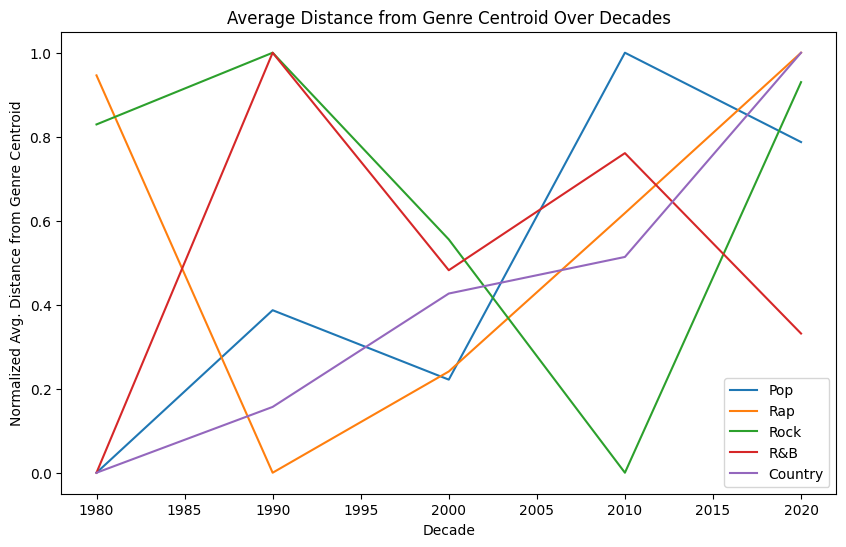

In [ ]:
dates = list(songs_df['year'])
genre = list(songs_df['tag'])

embeddings = reduced #dim=2

# init dictionaries for decades and genres
decades = [1980, 1990, 2000, 2010, 2020]
genres = ['pop', 'rock', 'rap', 'rb', 'country']
dates_dict = {decade: [] for decade in decades}
genre_dict = {genre: [] for genre in genres}

# song bin by decade
for i in range(len(dates)):
  if 1980 <= dates[i] < 1990:
    dates_dict[1980].append((embeddings[i], genre[i]))
  elif 1990 <= dates[i] < 2000:
    dates_dict[1990].append((embeddings[i], genre[i]))
  elif 2000 <= dates[i] < 2010:
    dates_dict[2000].append((embeddings[i], genre[i]))
  elif 2010 <= dates[i] < 2020:
    dates_dict[2010].append((embeddings[i], genre[i]))
  elif 2020 <= dates[i]:
    dates_dict[2020].append((embeddings[i], genre[i]))

# avg distance from genre centroids
for decade, songs in dates_dict.items():
  for genre in genres:
    # filter songs by genre
    relevant_songs = np.array([song[0] for song in songs if song[1] == genre])

    if len(relevant_songs) > 0:
      # centroid (mean embedding)
      mean_embedding = np.mean(relevant_songs, axis=0)

      # distances from centroid
      mean_loss = np.mean(np.linalg.norm(relevant_songs - mean_embedding, axis=1))
    else:
      mean_loss = 0  # no songs for genre in this decade

    genre_dict[genre].append(mean_loss)

# distance normalizing for plotting
def normalize(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr)) if len(arr) > 0 else arr

# arrays for each genre
pop_array = normalize(np.array(genre_dict['pop']))
rock_array = normalize(np.array(genre_dict['rock']))
rap_array = normalize(np.array(genre_dict['rap']))
rb_array = normalize(np.array(genre_dict['rb']))
country_array = normalize(np.array(genre_dict['country']))

# plotting results
plt.figure(figsize=(10, 6))
plt.plot(decades, pop_array, label='Pop')
plt.plot(decades, rap_array, label='Rap')
plt.plot(decades, rock_array, label='Rock')
plt.plot(decades, rb_array, label='R&B')
plt.plot(decades, country_array, label='Country')

plt.legend()
plt.xlabel("Decade")
plt.ylabel("Normalized Avg. Distance from Genre Centroid")
plt.title("Average Distance from Genre Centroid Over Decades")
plt.show()

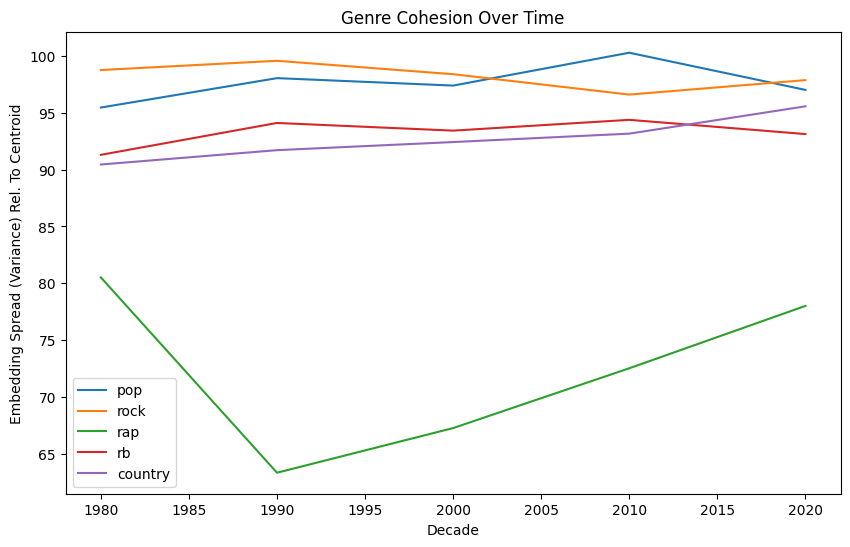

In [ ]:
decades = [1980, 1990, 2000, 2010, 2020]
genres = ['pop', 'rock', 'rap', 'rb', 'country']

# filter songs into bins by decade
def bin_by_decade(songs_df, cls_embeddings, decades):
  decade_dict = {decade: [] for decade in decades}
  for i, row in songs_df.iterrows():
    year = row['year']
    tag = row['tag']
    embedding = cls_embeddings[i]
    for decade in decades:
      if decade <= year < decade + 10:
        decade_dict[decade].append((embedding, tag))
  return decade_dict

dates_dict = bin_by_decade(songs_df, cls_embeddings, decades)
#dates_dict = bin_by_decade(songs_df, graphable, decades)
#dates_dict = bin_by_decade(songs_df, reduced, decades)


# genre cohesion (variance) over time
def compute_genre_cohesion(dates_dict, genres):
  cohesion_dict = {genre: [] for genre in genres}
  for decade, songs in dates_dict.items():
    for genre in genres:
      # filter embeddings by genre
      relevant_songs = np.array([song[0] for song in songs if song[1] == genre])
      if len(relevant_songs) > 1:
        mean_embedding = np.mean(relevant_songs, axis = 0)
        variance = np.mean(np.linalg.norm(relevant_songs - mean_embedding, axis = 1) ** 2)
      else:
        variance = 0
      cohesion_dict[genre].append(variance)
  return cohesion_dict

# cohesion for each genre
cohesion_dict = compute_genre_cohesion(dates_dict, genres)

# plot of genre cohesion
plt.figure(figsize=(10, 6))
for genre, spreads in cohesion_dict.items():
    plt.plot(decades, spreads, label=genre)

plt.xlabel("Decade")
plt.ylabel("Embedding Spread (Variance) Rel. To Centroid")
plt.title("Genre Cohesion Over Time")
plt.legend()
plt.show()

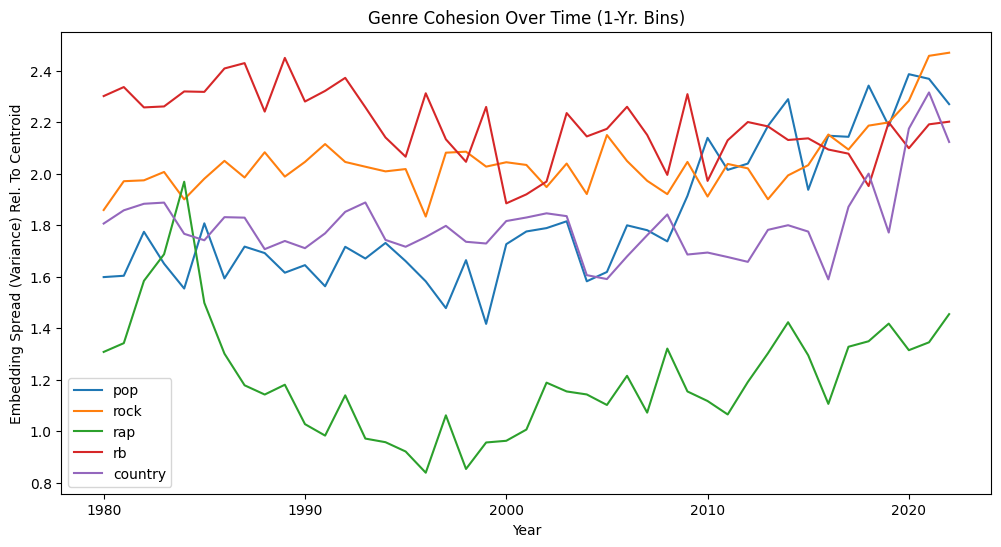

In [ ]:
# modifciation from above: UMAP + more granular binning (currently, just plotting for every year 1980-2022)
# apply umap
umap_reducer = umap.UMAP(n_neighbors=70, min_dist=0.1, n_components=5) # settings tweaked to capture global structure
umap_embeddings = umap_reducer.fit_transform(normalized_embeddings)

step = 1
bins = list(range(1980, 2023, step))
genres = ['pop', 'rock', 'rap', 'rb', 'country']

# filter songs into bins
def bin_by_interval(songs_df, cls_embeddings, bins, step):
  interval_dict = {interval: [] for interval in bins}
  for i, row in songs_df.iterrows():
    year = row['year']
    tag = row['tag']
    embedding = cls_embeddings[i]
    for interval in bins:
      if interval <= year < interval + step:
        interval_dict[interval].append((embedding, tag))
  return interval_dict

# (test) normalize embeddings before binning
dates_dict = bin_by_interval(songs_df, umap_embeddings, bins, step)

# genre cohesion over time
def compute_genre_cohesion(dates_dict, genres):
  cohesion_dict = {genre: [] for genre in genres}
  for interval, songs in dates_dict.items():
    for genre in genres:
      # filter embeddings by genre
      relevant_songs = np.array([song[0] for song in songs if song[1] == genre])
      if len(relevant_songs) > 1:
        mean_embedding = np.mean(relevant_songs, axis=0)
        variance = np.mean(np.linalg.norm(relevant_songs - mean_embedding, axis=1))
      else:
        variance = 0
      cohesion_dict[genre].append(variance)
  return cohesion_dict

cohesion_dict = compute_genre_cohesion(dates_dict, genres)

plt.figure(figsize=(12, 6))
for genre, spreads in cohesion_dict.items():
    plt.plot(bins, spreads, label=genre)

plt.xlabel("Year")
plt.ylabel("Embedding Spread (Variance) Rel. To Centroid")
plt.title(f"Genre Cohesion Over Time ({step}-Yr. Bins)")
plt.legend()
plt.show()

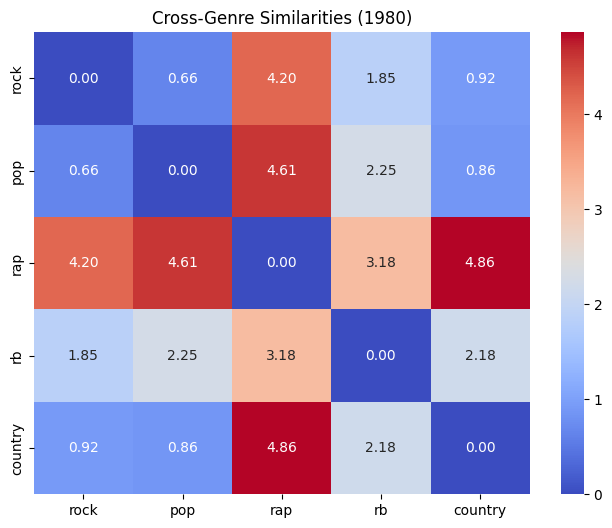

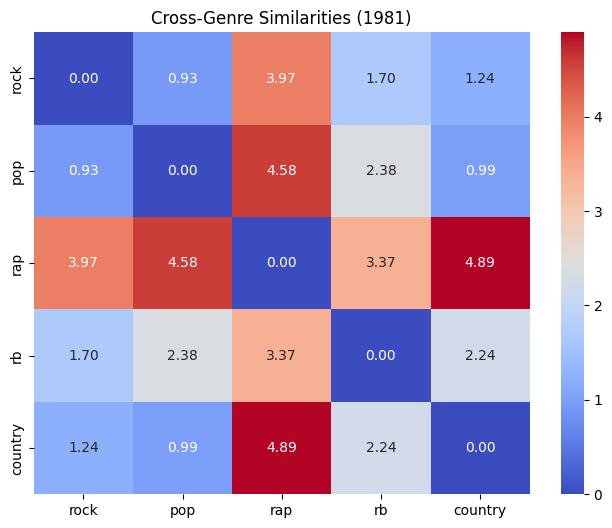

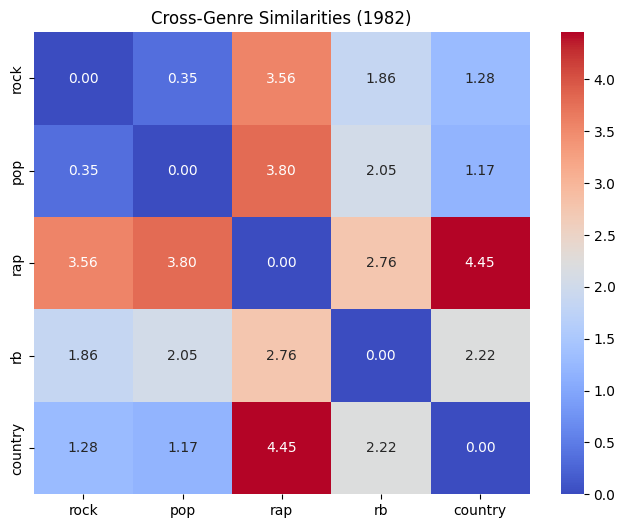

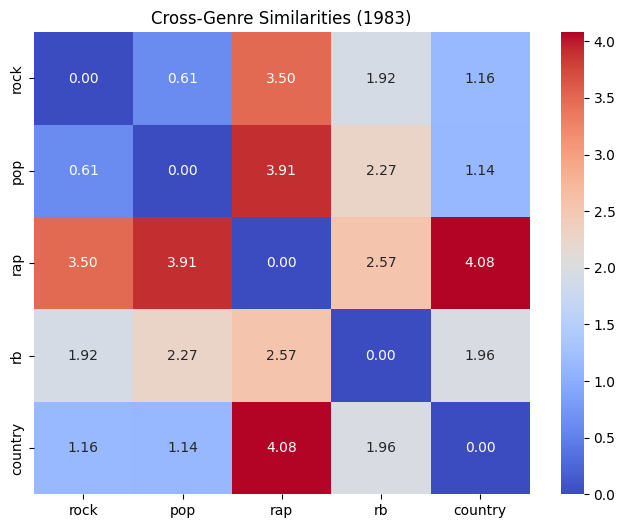

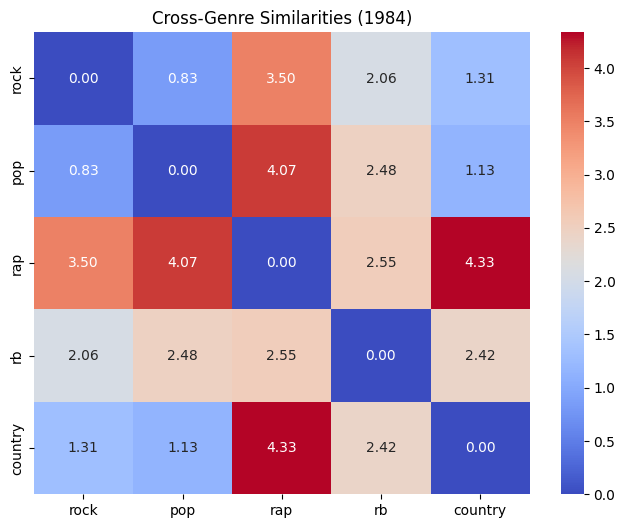

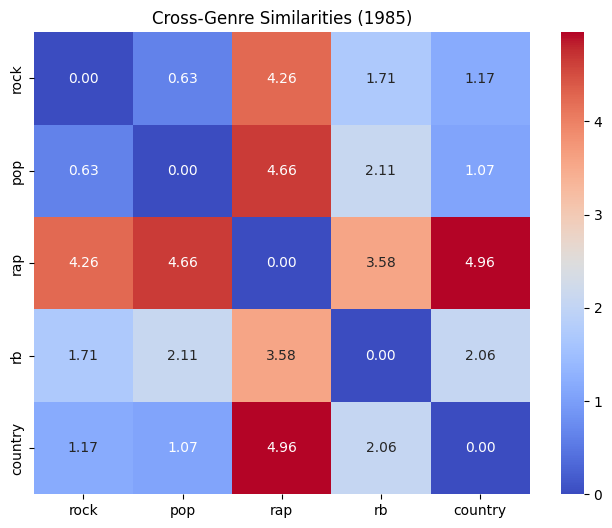

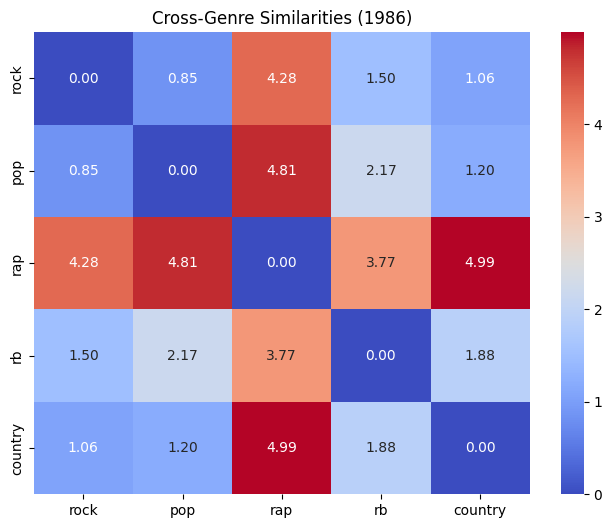

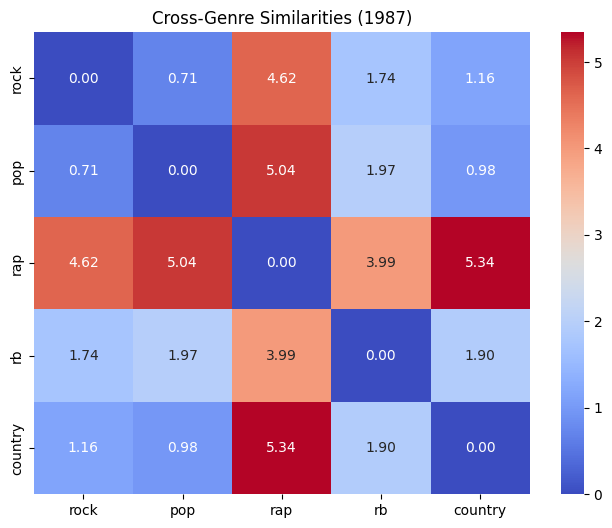

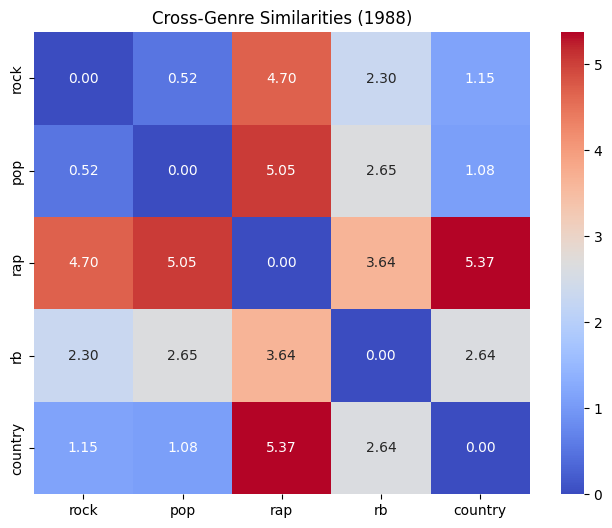

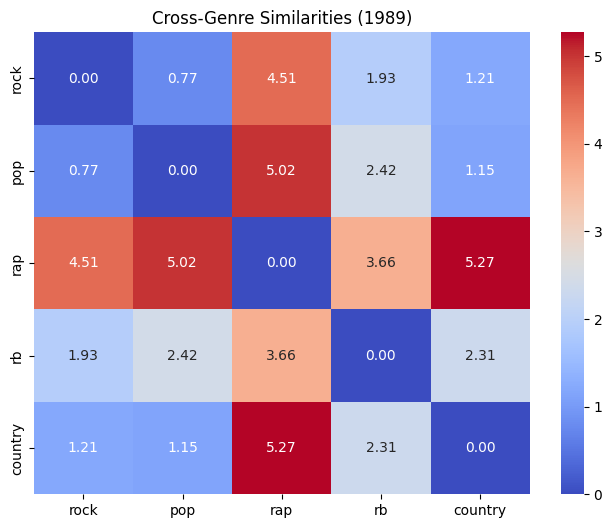

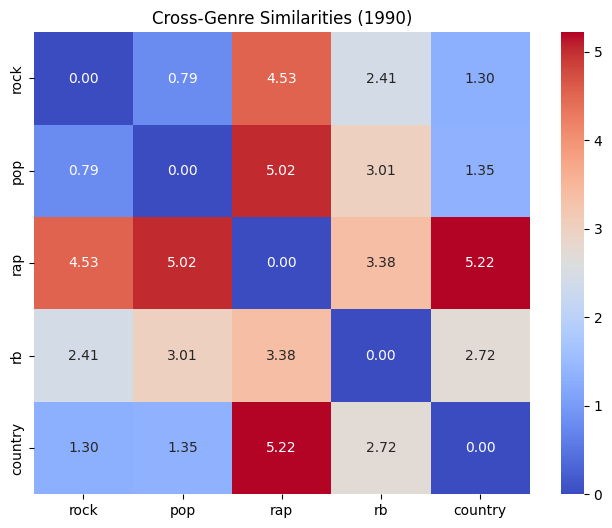

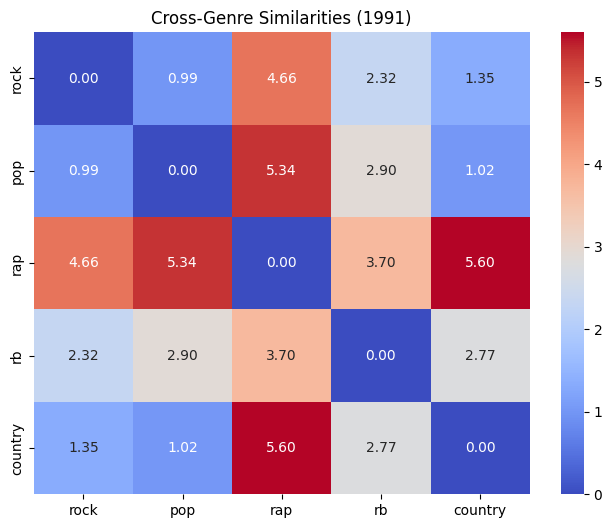

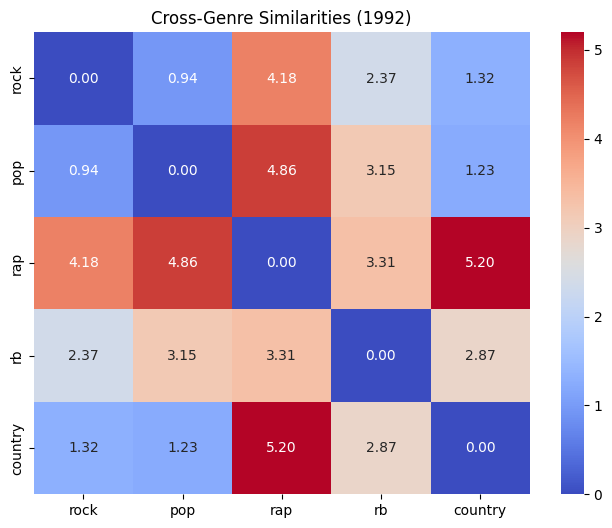

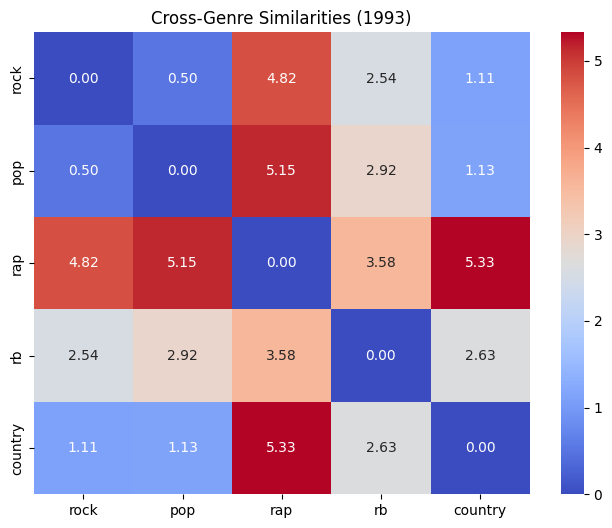

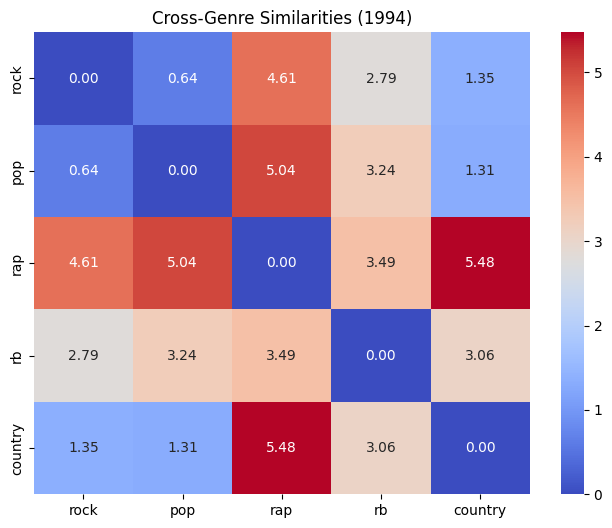

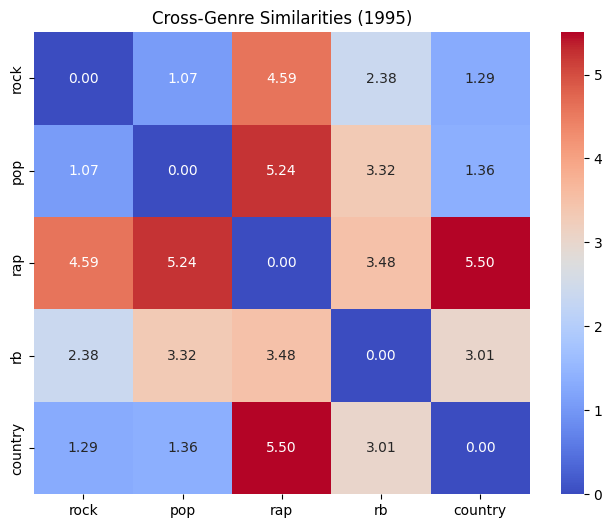

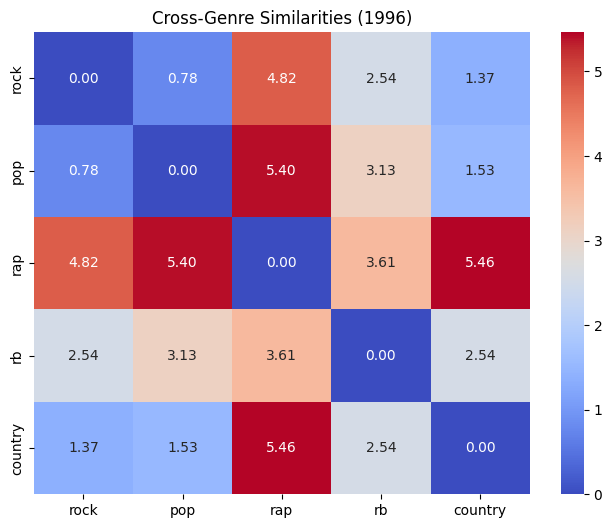

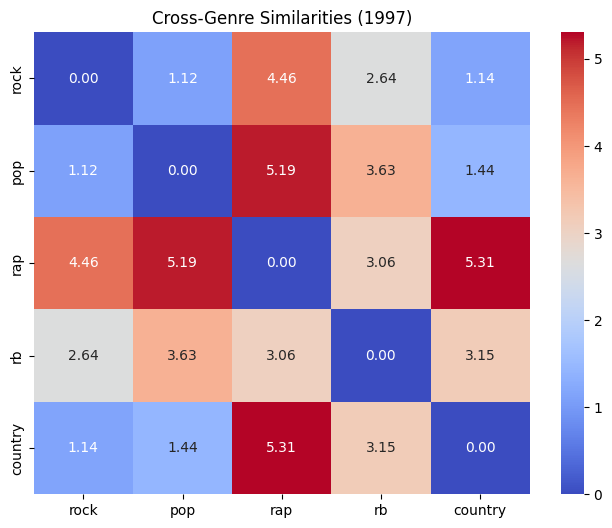

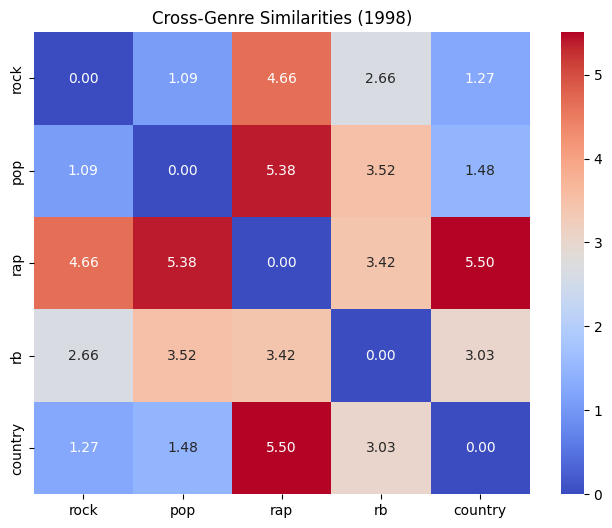

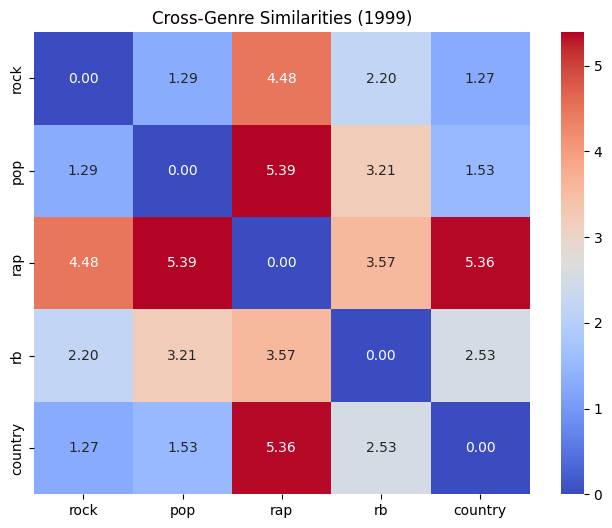

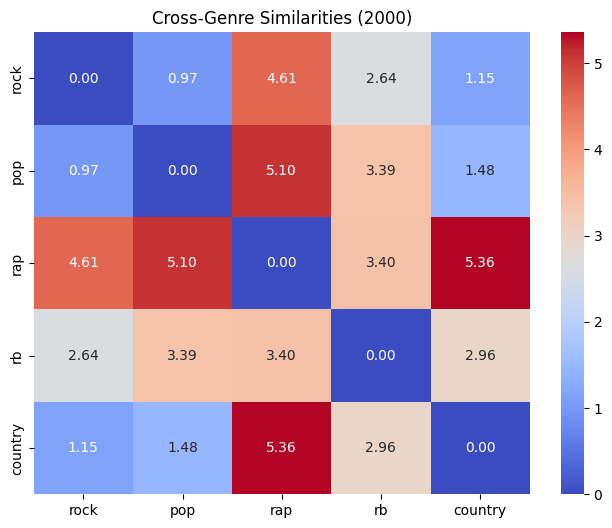

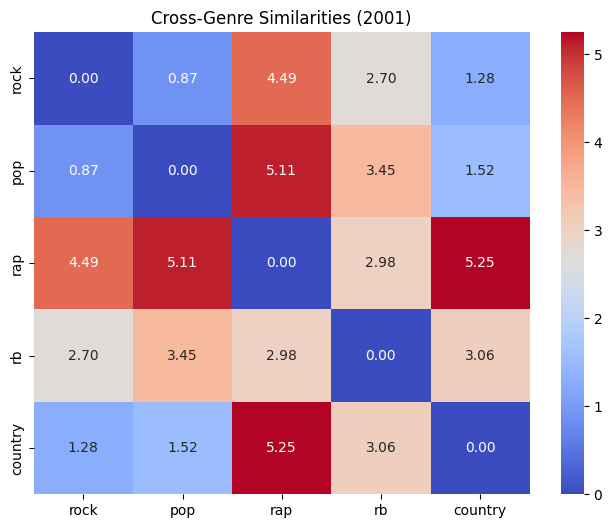

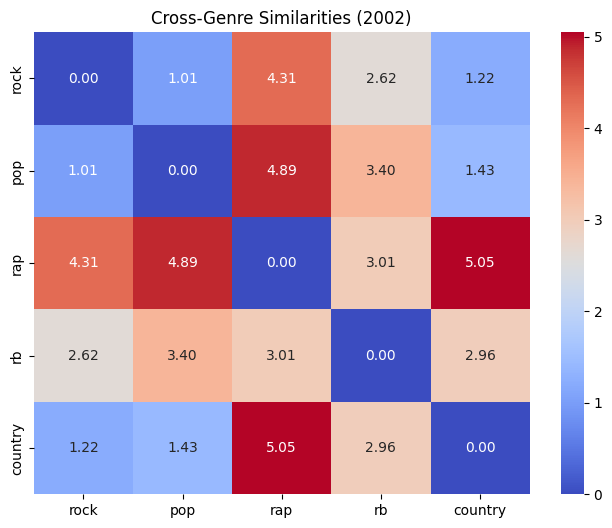

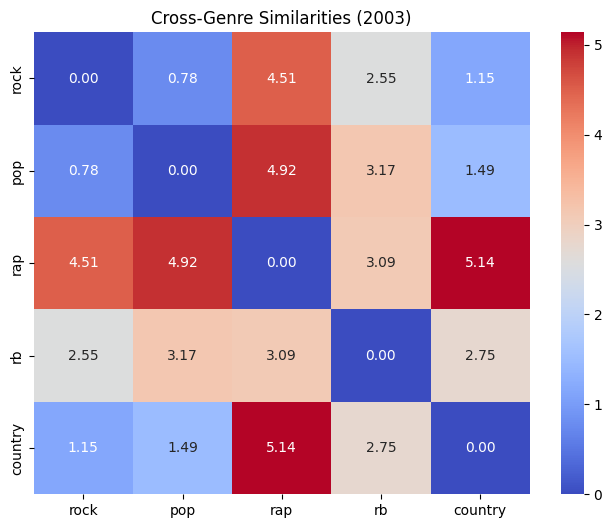

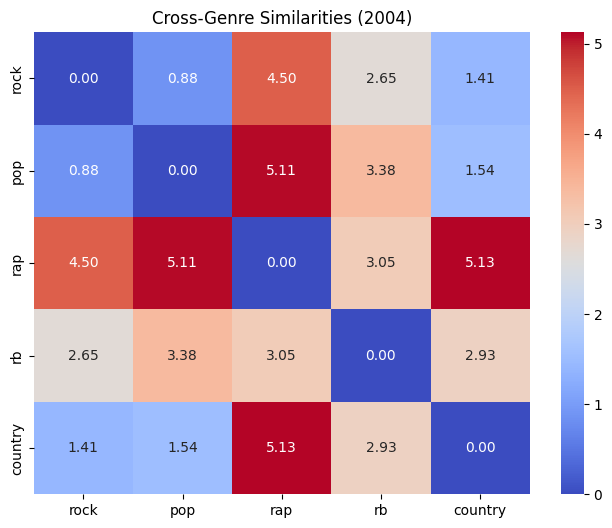

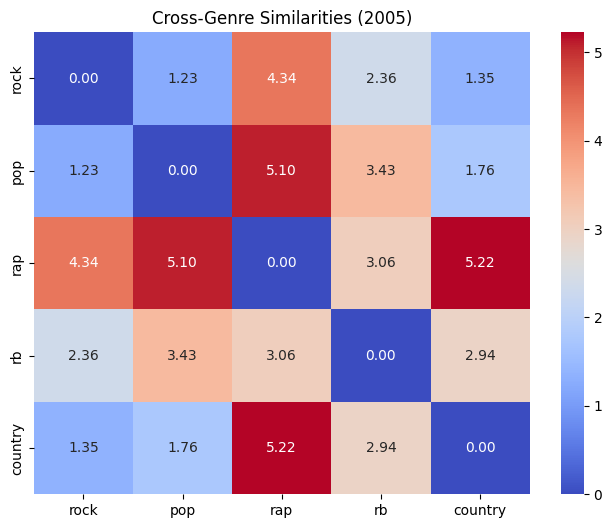

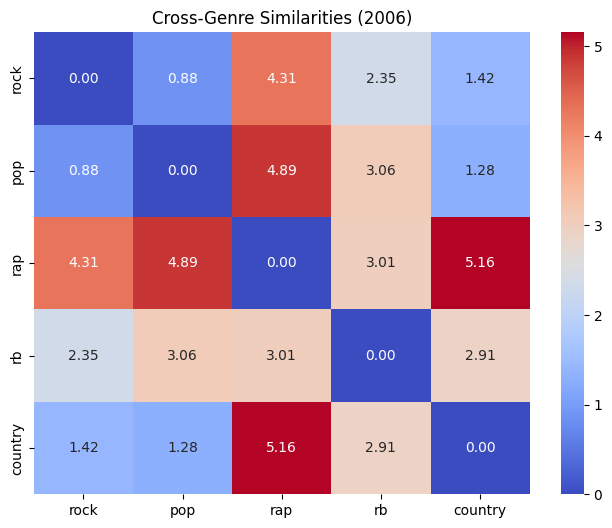

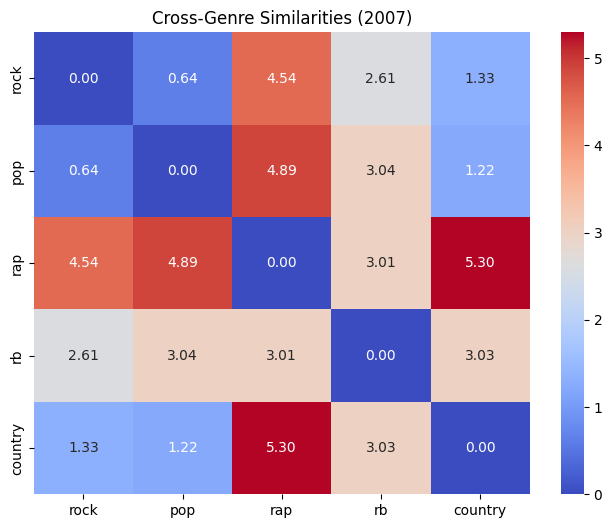

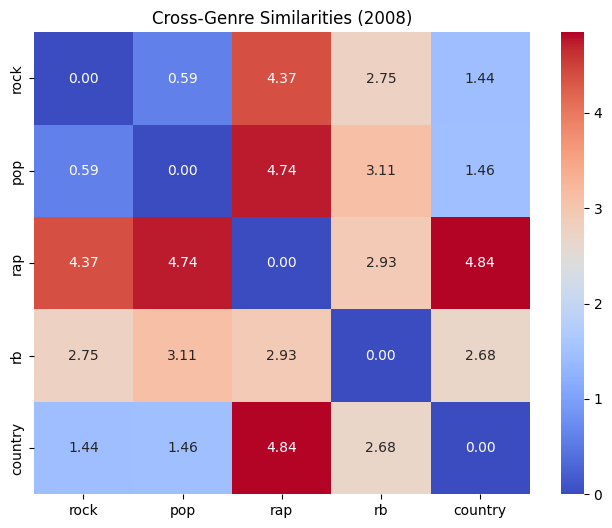

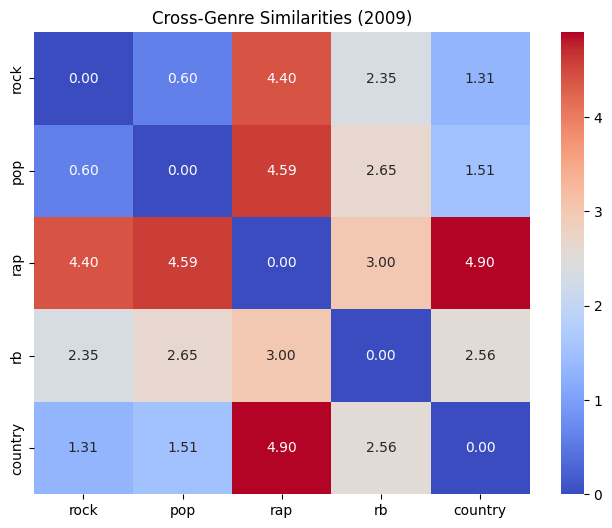

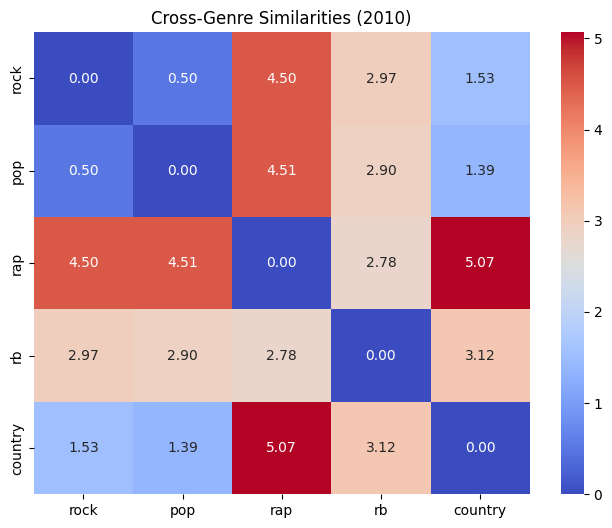

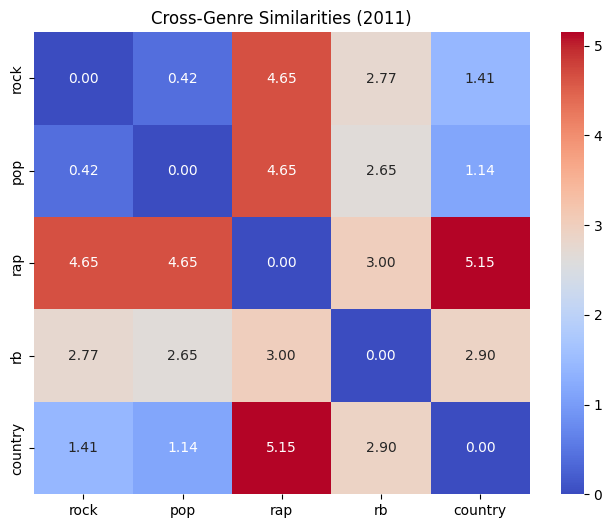

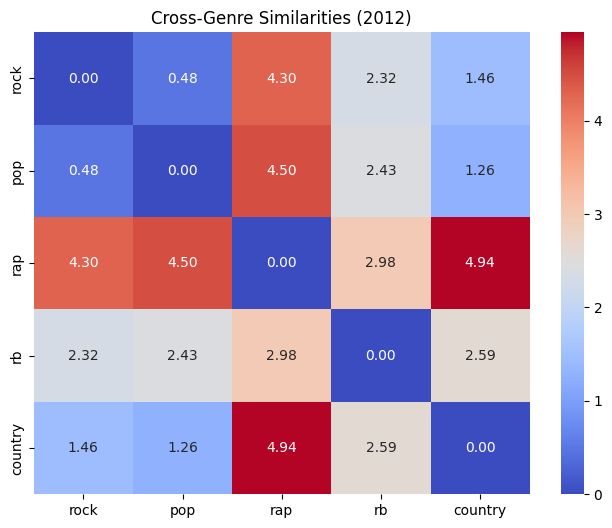

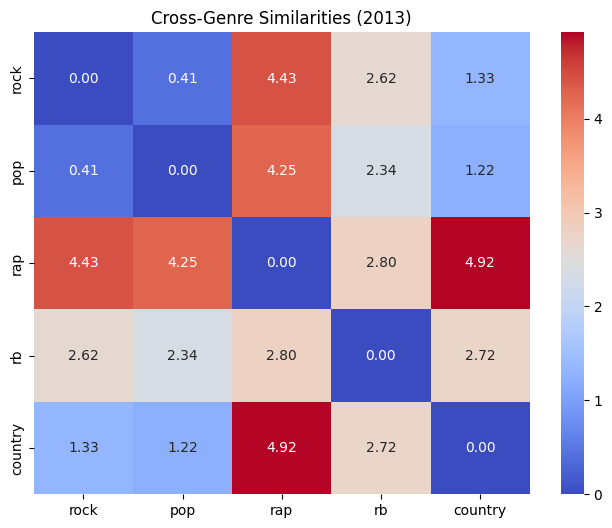

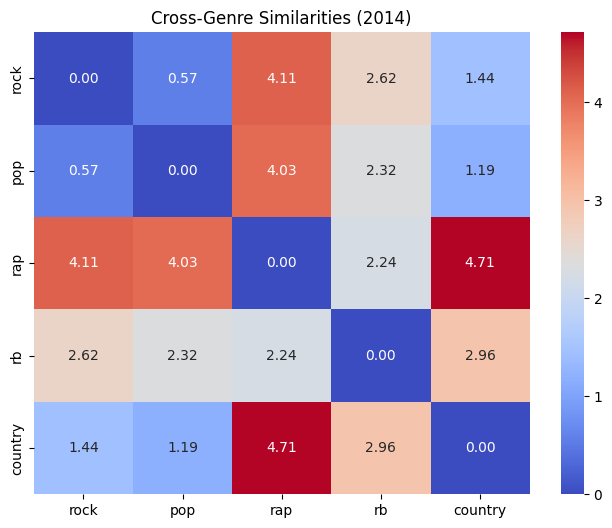

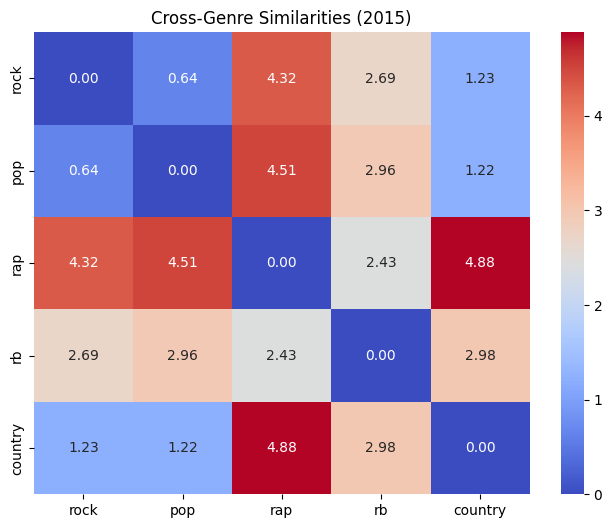

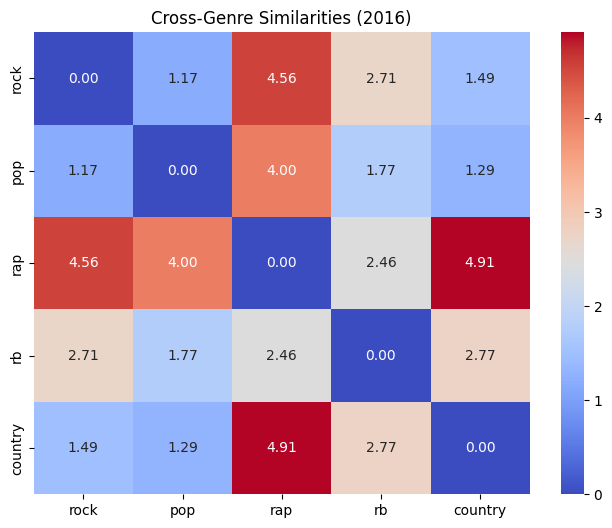

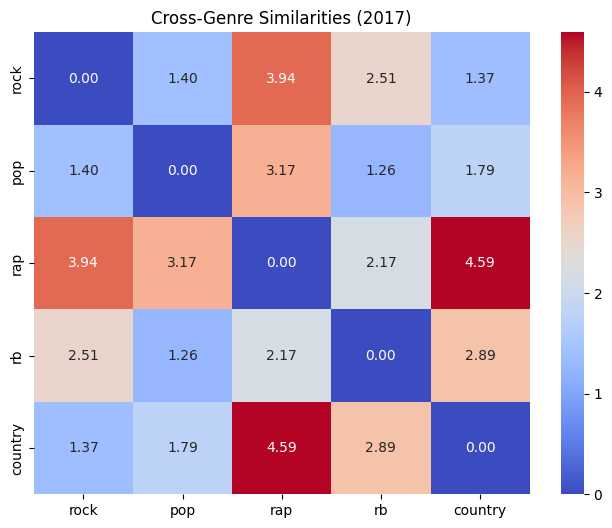

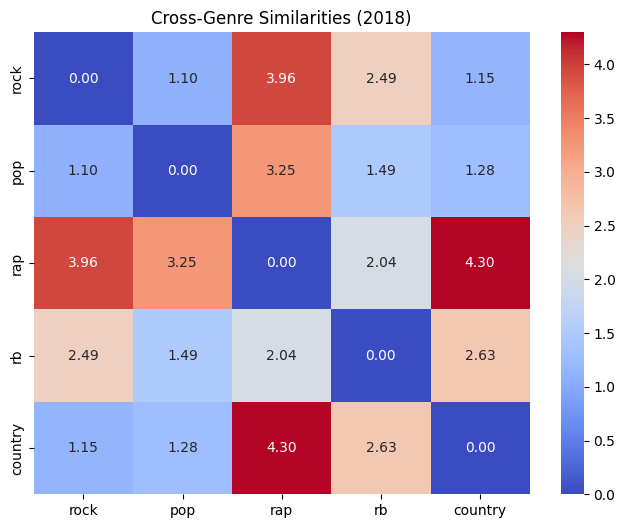

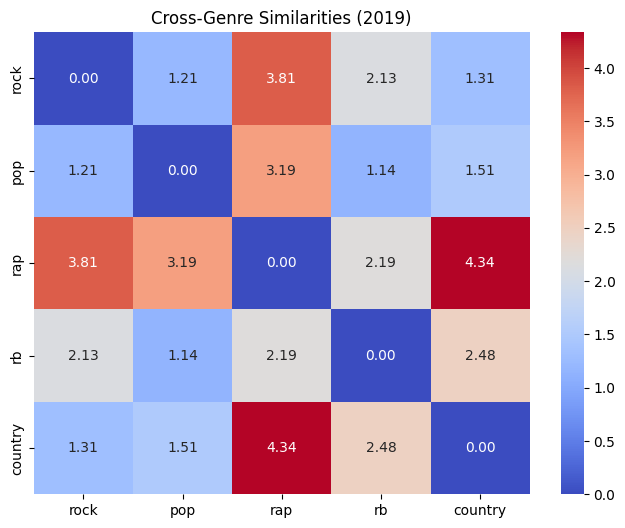

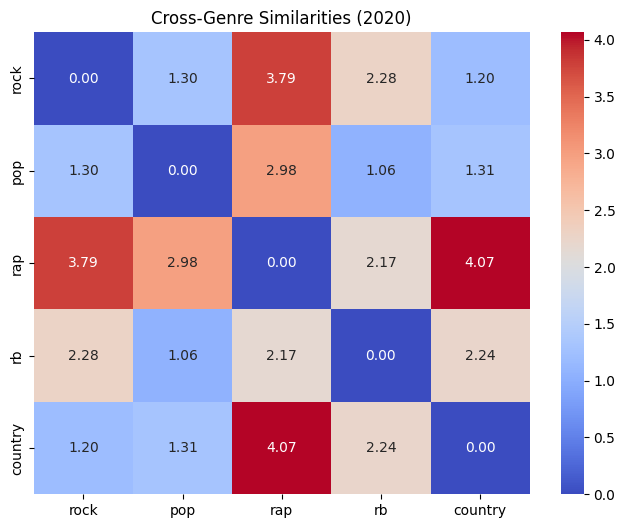

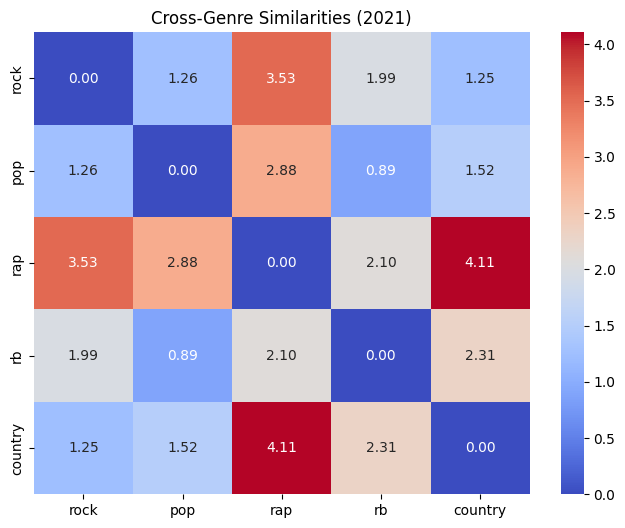

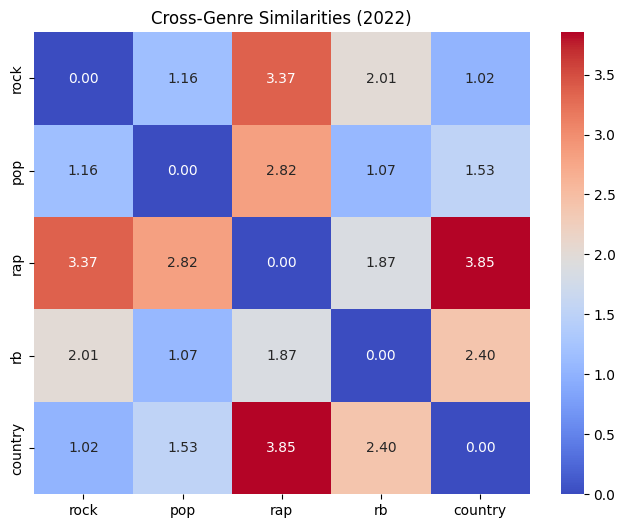

In [ ]:
# cross-genre similarities
def compute_cross_genre_similarities(dates_dict, genres):
  similarity_results = {}
  for decade, songs in dates_dict.items():
    centroids = {}
    for genre in genres:
      # centroid for the genre
      relevant_songs = np.array([song[0] for song in songs if song[1] == genre])
      if len(relevant_songs) > 0:
        centroids[genre] = np.mean(relevant_songs, axis=0)

    # pairwise distances
    genre_pairs = list(combinations(centroids.keys(), 2))
    similarities = {}
    for g1, g2 in genre_pairs:
      dist = np.linalg.norm(centroids[g1] - centroids[g2])
      similarities[(g1, g2)] = dist
    similarity_results[decade] = similarities

  return similarity_results

cross_genre_similarities = compute_cross_genre_similarities(dates_dict, genres)

# heatmap viz for each decade
for decade, similarities in cross_genre_similarities.items():
  genres_present = list(set(g for pair in similarities.keys() for g in pair))
  distance_matrix = np.zeros((len(genres_present), len(genres_present)))

  for i, g1 in enumerate(genres_present):
    for j, g2 in enumerate(genres_present):
      if (g1, g2) in similarities:
        distance_matrix[i, j] = similarities[(g1, g2)]
      elif (g2, g1) in similarities:
        distance_matrix[i, j] = similarities[(g2, g1)]

  plt.figure(figsize=(8, 6))
  sns.heatmap(distance_matrix, xticklabels=genres_present, yticklabels=genres_present, annot=True, fmt=".2f", cmap="coolwarm")
  plt.title(f"Cross-Genre Similarities ({decade})")
  plt.show()

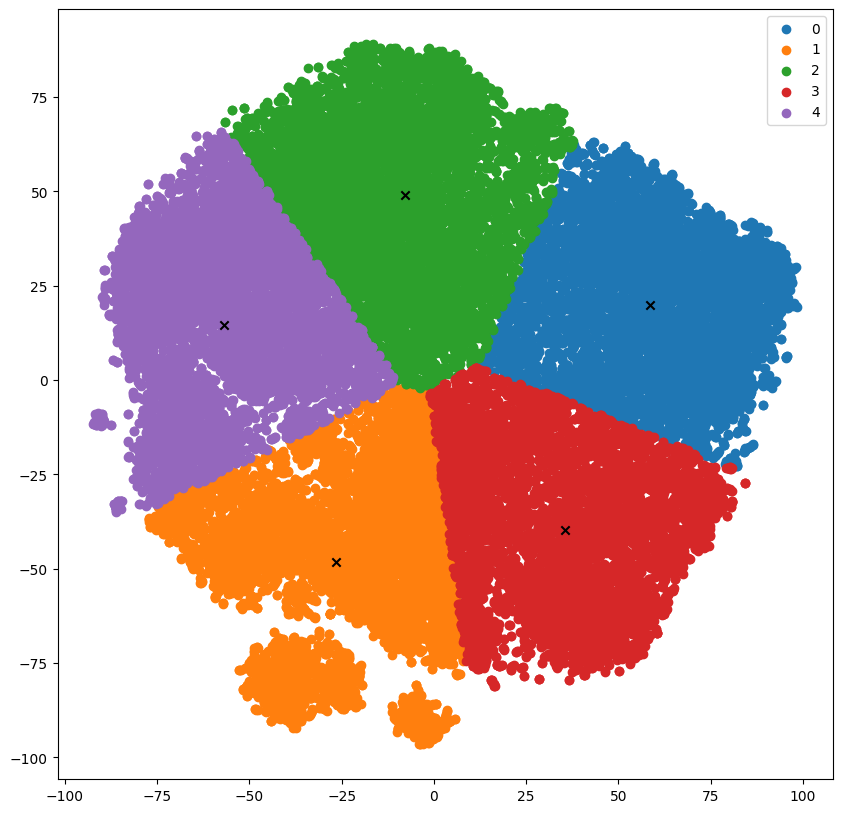

In [ ]:
# clustering plots
kmeans = KMeans(n_clusters=5, random_state=0).fit(graphable)
centers = np.array(kmeans.cluster_centers_)
labels = kmeans.predict(graphable)

plt.figure(figsize=(10,10))
uniq = np.unique(labels)

for i in uniq:
  plt.scatter(graphable[labels == i , 0] , graphable[labels == i , 1] , label = i)

# done to find the centroid for each clusters.
plt.scatter(centers[:,0], centers[:,1], marker="x", color='k')
plt.legend()
plt.show()

[1980, 2000, 2020]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Mean accuracy: 0.6386627906976744
F1 score: 0.6331176531391175


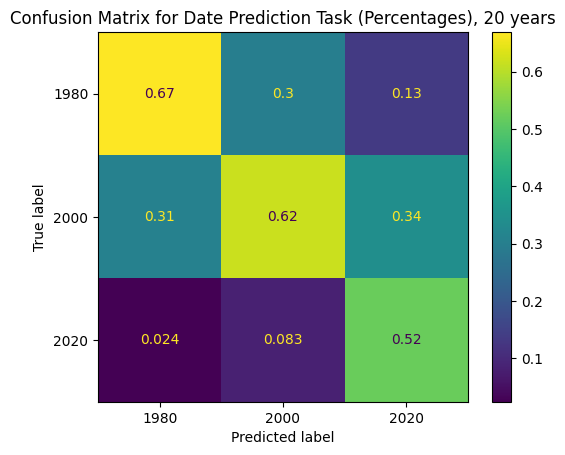

In [ ]:
# 20 year bins
release_year_bins = [i for i in range(1980, 2025, 20)]
print(release_year_bins)
new_release_years = []
all_release_years = list(songs_df['year'])
for year in all_release_years:
  if 1980 <= year < 2000:
    new_release_years.append(1980)
  elif 2000 <= year < 2020:
    new_release_years.append(2000)
  elif 2020 <= year:
    new_release_years.append(2020)

# one_dim = TSNE(n_components=1, learning_rate='auto', init='random', perplexity=15).fit_transform(graphable)
embed_train, embed_test, labels_train, labels_test = train_test_split(cls_embeddings, new_release_years, test_size=0.2, random_state=0)

log_reg_model = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg')
log_reg_model.fit(embed_train, labels_train)
date_pred = log_reg_model.predict(embed_test)

# new_labels_test = np.array(labels_test)

log_score = log_reg_model.score(embed_test, labels_test)
f1 = f1_score(labels_test, date_pred, average='weighted')
print(f"Mean accuracy: {log_score}")
print(f"F1 score: {f1}")

cm = confusion_matrix(labels_test, date_pred, normalize='pred')
matrix = ConfusionMatrixDisplay(cm, display_labels=release_year_bins)
matrix.plot()
plt.title("Confusion Matrix for Date Prediction Task (Percentages), 20 years")
plt.show()

# plt.scatter(embed_test, labels_test, color="black")
# plt.plot(embed_test, labels_test, color="blue", linewidth=3)
# plt.show()

[1980, 1995, 2010]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Mean accuracy: 0.5390988372093023
F1 score: 0.5382584801354776


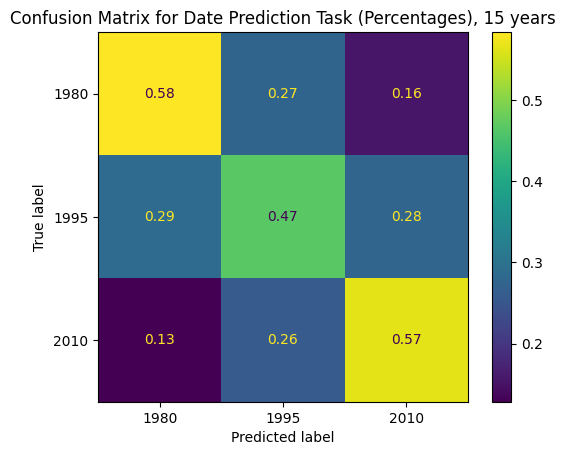

In [ ]:
# 15 year bins
fifteen_release_year_bins = [i for i in range(1980, 2025, 15)]
print(fifteen_release_year_bins)
new_release_years = []
all_release_years = list(songs_df['year'])
for year in all_release_years:
  if 1980 <= year < 1995:
    new_release_years.append(1980)
  elif 1995 <= year < 2010:
    new_release_years.append(1995)
  elif 2010 <= year:
    new_release_years.append(2010)


# one_dim = TSNE(n_components=1, learning_rate='auto', init='random', perplexity=15).fit_transform(graphable)
embed_train, embed_test, labels_train, labels_test = train_test_split(cls_embeddings, new_release_years, test_size=0.2, random_state=0)


log_reg_model = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg')
log_reg_model.fit(embed_train, labels_train)
date_pred = log_reg_model.predict(embed_test)
# new_labels_test = np.array(labels_test)


log_score = log_reg_model.score(embed_test, labels_test)
f1 = f1_score(labels_test, date_pred, average='weighted')
print(f"Mean accuracy: {log_score}")
print(f"F1 score: {f1}")


cm = confusion_matrix(labels_test, date_pred, normalize='pred')
matrix = ConfusionMatrixDisplay(cm, display_labels=fifteen_release_year_bins)
matrix.plot()
plt.title("Confusion Matrix for Date Prediction Task (Percentages), 15 years")
plt.show()

[1980, 1990, 2000, 2010, 2020]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Mean accuracy: 0.39578488372093024
F1 score: 0.3909026138270325


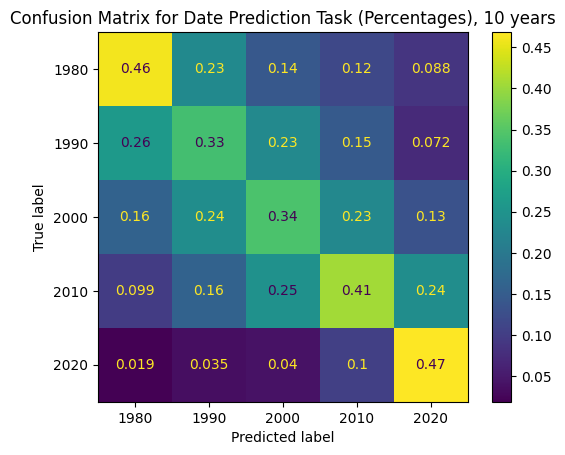

In [ ]:
# decades bins -- new logic (i.e. song release in 1989 still gets categorized as 1980 instead of 1990)
ten_release_year_bins = [i for i in range(1980, 2025, 10)]
print(ten_release_year_bins)
new_release_years = []
all_release_years = list(songs_df['year'])
for year in all_release_years:
  if 1980 <= year < 1990:
    new_release_years.append(1980)
  elif 1990 <= year < 2000:
    new_release_years.append(1990)
  elif 2000 <= year < 2010:
    new_release_years.append(2000)
  elif 2010 <= year < 2020:
    new_release_years.append(2010)
  elif 2020 <= year:
    new_release_years.append(2020)

# one_dim = TSNE(n_components=1, learning_rate='auto', init='random', perplexity=15).fit_transform(graphable)
embed_train, embed_test, labels_train, labels_test = train_test_split(cls_embeddings, new_release_years, test_size=0.2, random_state=0)


log_reg_model = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg')
log_reg_model.fit(embed_train, labels_train)
date_pred = log_reg_model.predict(embed_test)
# new_labels_test = np.array(labels_test)


log_score = log_reg_model.score(embed_test, labels_test)
f1 = f1_score(labels_test, date_pred, average='weighted')
print(f"Mean accuracy: {log_score}")
print(f"F1 score: {f1}")


cm = confusion_matrix(labels_test, date_pred, normalize='pred')
matrix = ConfusionMatrixDisplay(cm, display_labels=ten_release_year_bins)
matrix.plot()
plt.title("Confusion Matrix for Date Prediction Task (Percentages), 10 years")
plt.show()

[1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Mean accuracy: 0.2385174418604651
F1 score: 0.23431678199670286


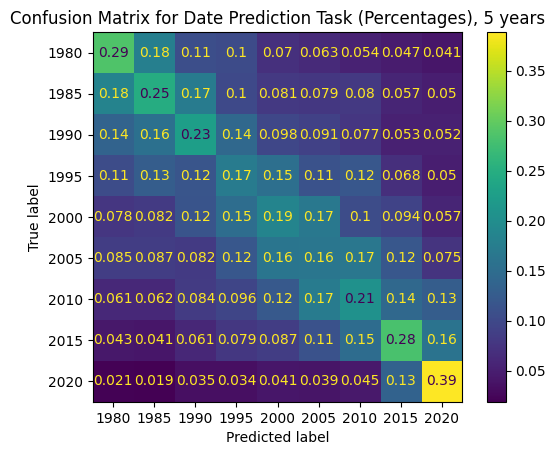

In [ ]:
# five years bins
five_release_year_bins = [i for i in range(1980, 2025, 5)]
print(five_release_year_bins)
new_release_years = []
all_release_years = list(songs_df['year'])
for year in all_release_years:
  if 1980 <= year < 1985:
    new_release_years.append(1980)
  elif 1985 <= year < 1990:
    new_release_years.append(1985)
  elif 1990 <= year < 1995:
    new_release_years.append(1990)
  elif 1995 <= year < 2000:
    new_release_years.append(1995)
  elif 2000 <= year < 2005:
    new_release_years.append(2000)
  elif 2005 <= year < 2010:
    new_release_years.append(2005)
  elif 2010 <= year < 2015:
    new_release_years.append(2010)
  elif 2015 <= year < 2020:
    new_release_years.append(2015)
  elif 2020 <= year:
    new_release_years.append(2020)


# one_dim = TSNE(n_components=1, learning_rate='auto', init='random', perplexity=15).fit_transform(graphable)
embed_train, embed_test, labels_train, labels_test = train_test_split(cls_embeddings, new_release_years, test_size=0.2, random_state=0)


log_reg_model = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg')
log_reg_model.fit(embed_train, labels_train)
date_pred = log_reg_model.predict(embed_test)
# new_labels_test = np.array(labels_test)


log_score = log_reg_model.score(embed_test, labels_test)
f1 = f1_score(labels_test, date_pred, average='weighted')
print(f"Mean accuracy: {log_score}")
print(f"F1 score: {f1}")


cm = confusion_matrix(labels_test, date_pred, normalize='pred')
matrix = ConfusionMatrixDisplay(cm, display_labels=five_release_year_bins)
matrix.plot()
plt.title("Confusion Matrix for Date Prediction Task (Percentages), 5 years")
plt.show()